# Prédiction de solvabilité avec KNN

Ce notebook présente un mini-projet de data science appliquant l'algorithme KNN (K-Nearest Neighbors) pour prédire la solvabilité des clients à partir de données financières fictives.

## Objectif
Prédire si un client est **solvable** ou **non solvable** à partir de ses caractéristiques financières.

## 1. Importation des bibliothèques nécessaires

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.decomposition import PCA
import os

# Configuration pour les graphiques
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Définir un seed pour la reproductibilité
np.random.seed(42)

## 2. Génération du jeu de données fictif

Nous allons créer un jeu de données fictif de 1000 clients avec les caractéristiques financières suivantes :
- Âge
- Revenu annuel
- Montant du crédit
- Ratio dette/revenu
- Ancienneté d'emploi
- Nombre de crédits actifs
- Historique de paiement

La variable cible sera la **solvabilité** (0: Non solvable, 1: Solvable).

In [2]:
# Génération de données fictives pour 1000 clients
n_samples = 1000

# Caractéristiques financières
age = np.random.normal(40, 10, n_samples).astype(int)  # Âge moyen de 40 ans
age = np.clip(age, 18, 75)  # Limiter l'âge entre 18 et 75 ans

revenu_annuel = np.random.normal(45000, 15000, n_samples)  # Revenu annuel moyen de 45000€
revenu_annuel = np.clip(revenu_annuel, 15000, 120000)  # Limiter le revenu entre 15000€ et 120000€

montant_credit = np.random.normal(20000, 10000, n_samples)  # Montant du crédit moyen de 20000€
montant_credit = np.clip(montant_credit, 1000, 80000)  # Limiter le montant entre 1000€ et 80000€

ratio_dette_revenu = np.random.normal(0.3, 0.15, n_samples)  # Ratio dette/revenu moyen de 30%
ratio_dette_revenu = np.clip(ratio_dette_revenu, 0.05, 0.9)  # Limiter le ratio entre 5% et 90%

anciennete_emploi = np.random.normal(7, 4, n_samples).astype(int)  # Ancienneté moyenne de 7 ans
anciennete_emploi = np.clip(anciennete_emploi, 0, 30)  # Limiter l'ancienneté entre 0 et 30 ans

nb_credits_actifs = np.random.poisson(2, n_samples)  # Nombre moyen de crédits actifs: 2
nb_credits_actifs = np.clip(nb_credits_actifs, 0, 10)  # Limiter le nombre entre 0 et 10

historique_paiement = np.random.normal(0.9, 0.2, n_samples)  # Score d'historique de paiement (0-1)
historique_paiement = np.clip(historique_paiement, 0, 1)  # Limiter le score entre 0 et 1

# Création d'une règle pour déterminer la solvabilité (variable cible)
# Un client est considéré solvable si:
# - Son ratio dette/revenu est inférieur à 0.4
# - Son historique de paiement est supérieur à 0.7
# - Il a moins de 5 crédits actifs
# - Son ancienneté d'emploi est supérieure à 2 ans
# Avec un peu de bruit pour rendre le problème plus réaliste

solvabilite_score = (
    (ratio_dette_revenu < 0.4) * 0.4 +
    (historique_paiement > 0.7) * 0.3 +
    (nb_credits_actifs < 5) * 0.2 +
    (anciennete_emploi > 2) * 0.1 +
    np.random.normal(0, 0.1, n_samples)  # Ajout de bruit
)

# Conversion en variable binaire (0: Non solvable, 1: Solvable)
solvabilite = (solvabilite_score > 0.6).astype(int)

# Création du DataFrame
data = pd.DataFrame({
    'Age': age,
    'Revenu_Annuel': revenu_annuel,
    'Montant_Credit': montant_credit,
    'Ratio_Dette_Revenu': ratio_dette_revenu,
    'Anciennete_Emploi': anciennete_emploi,
    'Nb_Credits_Actifs': nb_credits_actifs,
    'Historique_Paiement': historique_paiement,
    'Solvabilite': solvabilite
})

# Affichage des premières lignes du jeu de données
print("Aperçu du jeu de données généré:")
data.head()

Aperçu du jeu de données généré:


,Age,Revenu_Annuel,Montant_Credit,Ratio_Dette_Revenu,Anciennete_Emploi,Nb_Credits_Actifs,Historique_Paiement,Solvabilite
0,44,65990.331549,13248.217250,0.050000,3,1,0.873187,1
1,38,58869.505244,18554.813293,0.170942,6,1,0.685308,1
2,46,45894.455549,12075.800790,0.237959,7,2,1.000000,1
3,55,35295.948334,16920.384704,0.583153,8,2,0.914640,1
4,37,55473.349704,1063.853330,0.383483,1,3,1.000000,1


In [3]:
# Statistiques descriptives
print("Statistiques descriptives:")
data.describe()

Statistiques descriptives:


,Age,Revenu_Annuel,Montant_Credit,Ratio_Dette_Revenu,Anciennete_Emploi,Nb_Credits_Actifs,Historique_Paiement,Solvabilite
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,39.706000,46198.025895,20157.530385,0.300550,6.426000,1.923000,0.853677,0.810000
std,9.697195,14629.717402,9606.911733,0.147497,3.722416,1.314077,0.154151,0.392497
min,18.000000,15000.000000,1000.000000,0.050000,0.000000,0.000000,0.256789,0.000000
25%,33.000000,35906.374665,13520.003862,0.189387,4.000000,1.000000,0.753187,1.000000
50%,40.000000,45946.156985,19997.492352,0.300028,6.000000,2.000000,0.896498,1.000000
75%,46.000000,55933.232655,26609.153143,0.400042,9.000000,3.000000,1.000000,1.000000
max,75.000000,92896.613518,59262.377064,0.786464,19.000000,8.000000,1.000000,1.000000


In [4]:
# Distribution des classes
print("Distribution des classes (Solvabilité):")
print(data['Solvabilite'].value_counts())
print(f"Pourcentage de clients solvables: {data['Solvabilite'].mean() * 100:.2f}%")

Distribution des classes (Solvabilité):
Solvabilite
1    810
0    190
Name: count, dtype: int64
Pourcentage de clients solvables: 81.00%


### Visualisation de la distribution des caractéristiques

C:\Users\Admin\AppData\Local\Temp\ipykernel_22800\3156098714.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=data, ax=axes[i], palette=['#FF9999', '#66B2FF'])


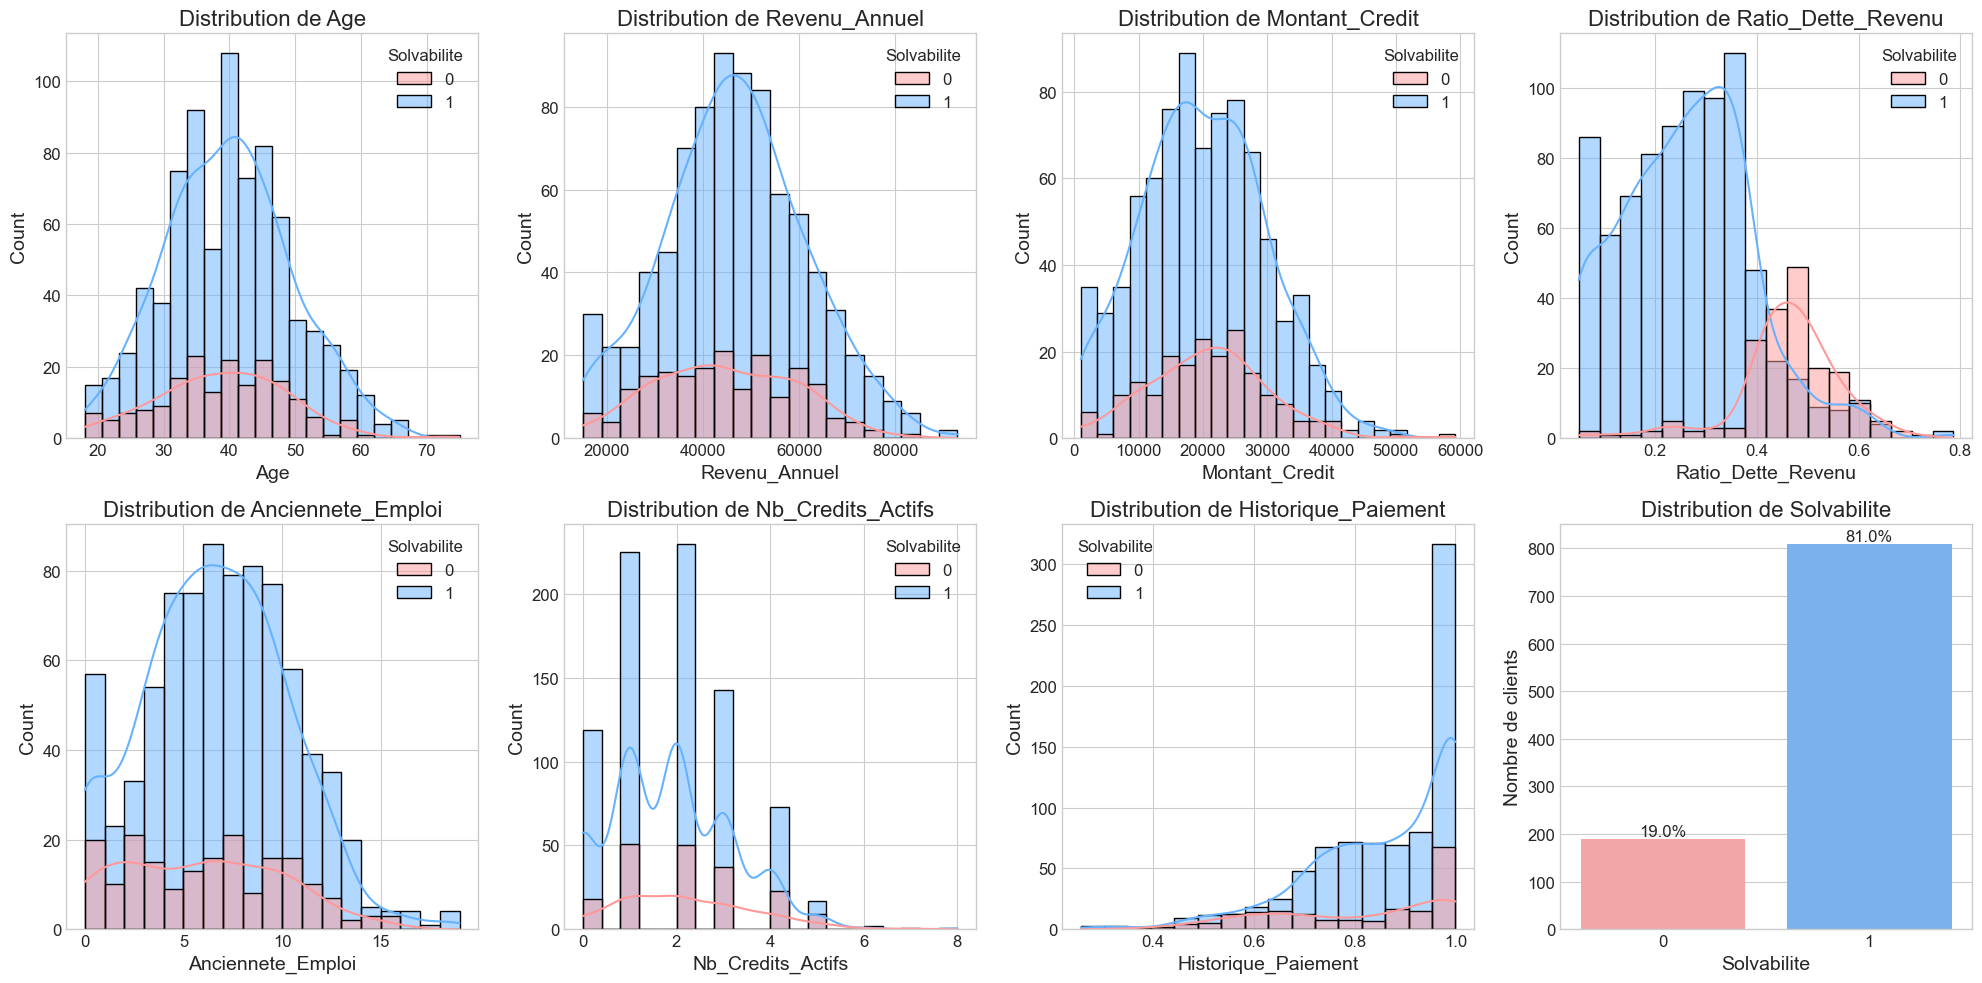

In [5]:
# Visualisation de la distribution des caractéristiques
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

# Histogrammes pour chaque caractéristique
for i, col in enumerate(data.columns):
    if col == 'Solvabilite':
        sns.countplot(x=col, data=data, ax=axes[i], palette=['#FF9999', '#66B2FF'])
        axes[i].set_title(f'Distribution de {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Nombre de clients')
        # Ajouter les pourcentages
        total = len(data)
        for p in axes[i].patches:
            percentage = f'{100 * p.get_height() / total:.1f}%'
            x = p.get_x() + p.get_width() / 2
            y = p.get_height()
            axes[i].annotate(percentage, (x, y), ha='center', va='bottom')
    else:
        sns.histplot(data=data, x=col, hue='Solvabilite', kde=True, ax=axes[i], palette=['#FF9999', '#66B2FF'])
        axes[i].set_title(f'Distribution de {col}')

plt.tight_layout()
plt.show()

### Matrice de corrélation

Examinons les corrélations entre les différentes caractéristiques pour mieux comprendre les relations entre elles.

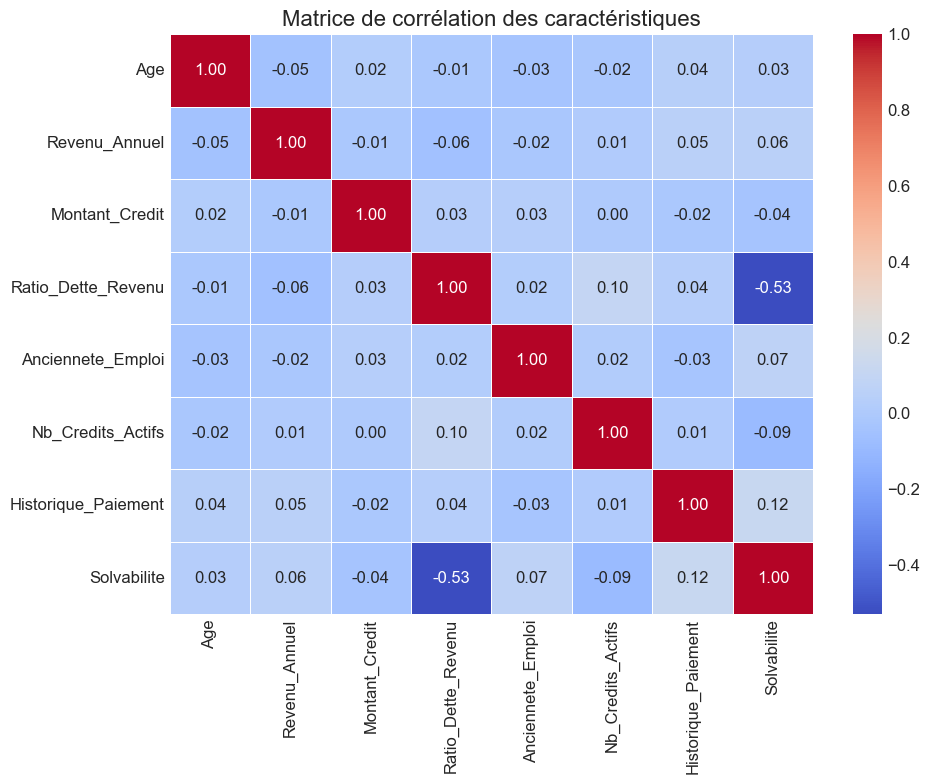

In [6]:
# Matrice de corrélation
plt.figure(figsize=(10, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matrice de corrélation des caractéristiques')
plt.tight_layout()
plt.show()

## 3. Préparation et normalisation des données

L'algorithme KNN est sensible à l'échelle des caractéristiques car il utilise la distance euclidienne. Il est donc important de normaliser les données pour que chaque caractéristique contribue équitablement au calcul de la distance.

In [7]:
# Séparation des caractéristiques et de la cible
X = data.drop('Solvabilite', axis=1)
y = data['Solvabilite']

print("Caractéristiques avant normalisation:")
X.describe().round(2)

Caractéristiques avant normalisation:


,Age,Revenu_Annuel,Montant_Credit,Ratio_Dette_Revenu,Anciennete_Emploi,Nb_Credits_Actifs,Historique_Paiement
count,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00
mean,39.71,46198.03,20157.53,0.30,6.43,1.92,0.85
std,9.70,14629.72,9606.91,0.15,3.72,1.31,0.15
min,18.00,15000.00,1000.00,0.05,0.00,0.00,0.26
25%,33.00,35906.37,13520.00,0.19,4.00,1.00,0.75
50%,40.00,45946.16,19997.49,0.30,6.00,2.00,0.90
75%,46.00,55933.23,26609.15,0.40,9.00,3.00,1.00
max,75.00,92896.61,59262.38,0.79,19.00,8.00,1.00


In [8]:
# Normalisation des données avec StandardScaler
print("Normalisation des données...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Conversion en DataFrame pour une meilleure visualisation
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print("Caractéristiques après normalisation:")
X_scaled_df.describe().round(2)

Normalisation des données...
Caractéristiques après normalisation:


,Age,Revenu_Annuel,Montant_Credit,Ratio_Dette_Revenu,Anciennete_Emploi,Nb_Credits_Actifs,Historique_Paiement
count,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00
mean,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-2.24,-2.13,-2.00,-1.70,-1.73,-1.46,-3.87
25%,-0.69,-0.70,-0.69,-0.75,-0.65,-0.70,-0.65
50%,0.03,-0.02,-0.02,-0.00,-0.11,0.06,0.28
75%,0.65,0.67,0.67,0.67,0.69,0.82,0.95
max,3.64,3.19,4.07,3.30,3.38,4.63,0.95


### Visualisation des données avant et après normalisation

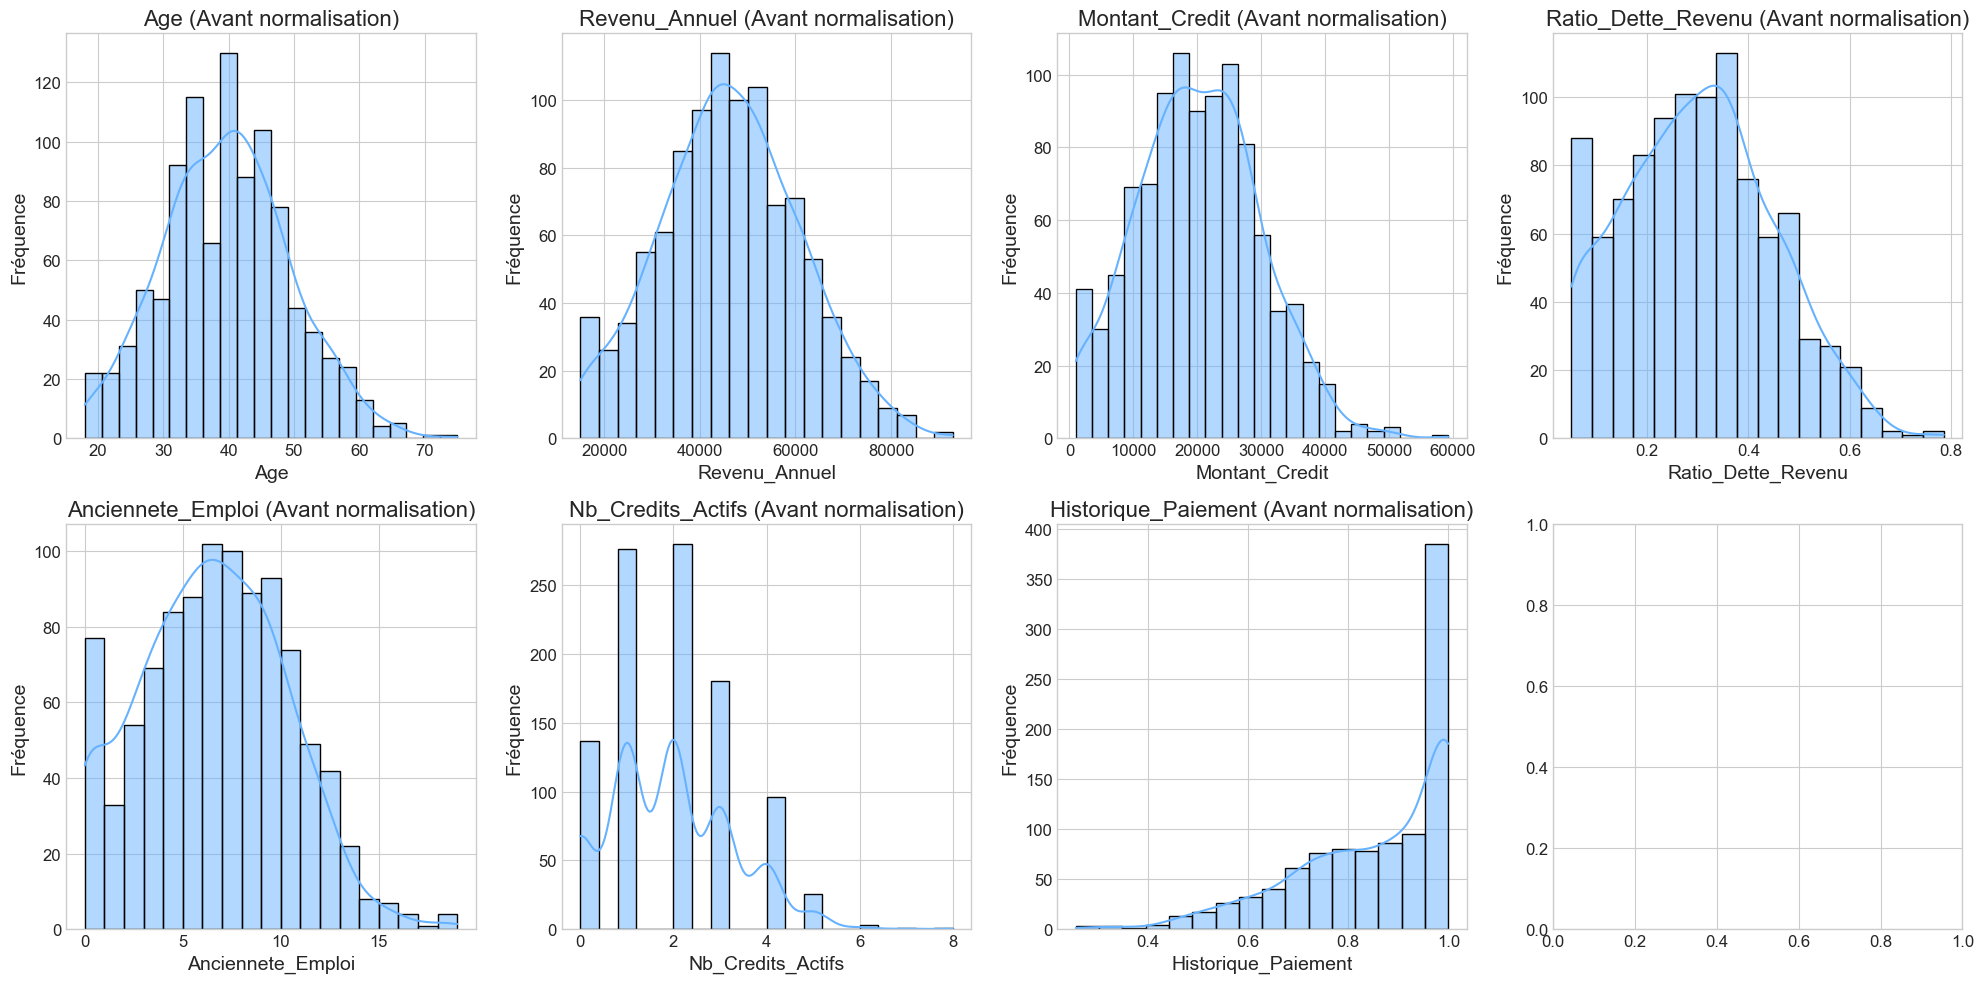

In [9]:
# Histogrammes avant normalisation
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(X.columns):
    sns.histplot(data=X, x=col, kde=True, ax=axes[i], color='#66B2FF')
    axes[i].set_title(f'{col} (Avant normalisation)')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Fréquence')

plt.tight_layout()
plt.show()

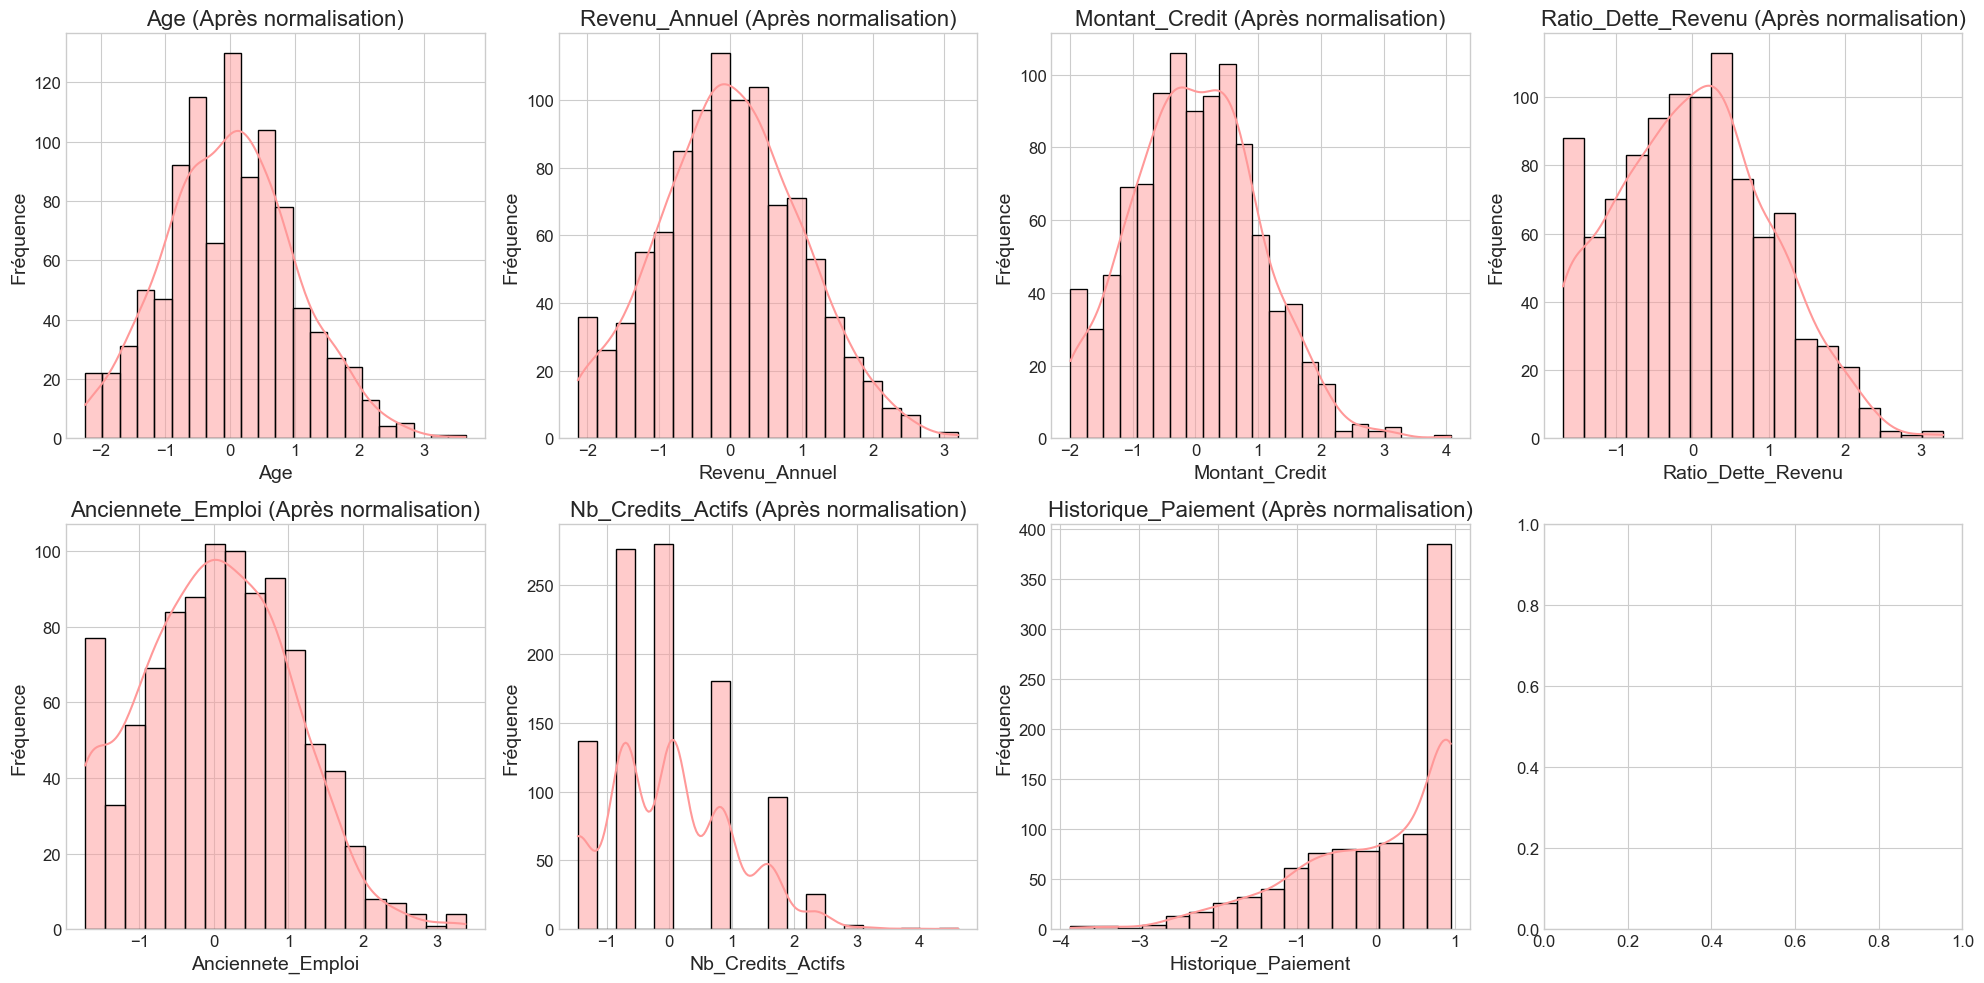

In [10]:
# Histogrammes après normalisation
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(X_scaled_df.columns):
    sns.histplot(data=X_scaled_df, x=col, kde=True, ax=axes[i], color='#FF9999')
    axes[i].set_title(f'{col} (Après normalisation)')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Fréquence')

plt.tight_layout()
plt.show()

## 4. Séparation en ensembles d'entraînement et de test

Nous allons diviser nos données en ensembles d'entraînement (80%) et de test (20%), en veillant à préserver la distribution des classes grâce à la stratification.

In [11]:
# Reconstitution du jeu de données complet normalisé
data_normalized = pd.DataFrame(X_scaled, columns=X.columns)
data_normalized['Solvabilite'] = y

# Séparation en ensembles d'entraînement et de test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print("Répartition des données:")
print(f"Ensemble d'entraînement: {X_train.shape[0]} échantillons ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Ensemble de test: {X_test.shape[0]} échantillons ({X_test.shape[0]/len(X)*100:.1f}%)")

Répartition des données:
Ensemble d'entraînement: 800 échantillons (80.0%)
Ensemble de test: 200 échantillons (20.0%)


In [12]:
# Vérification de la distribution des classes dans les ensembles d'entraînement et de test
print("Distribution des classes dans l'ensemble d'entraînement:")
print(y_train.value_counts())
print(f"Pourcentage de clients solvables: {y_train.mean() * 100:.2f}%")

print("\nDistribution des classes dans l'ensemble de test:")
print(y_test.value_counts())
print(f"Pourcentage de clients solvables: {y_test.mean() * 100:.2f}%")

Distribution des classes dans l'ensemble d'entraînement:
Solvabilite
1    648
0    152
Name: count, dtype: int64
Pourcentage de clients solvables: 81.00%

Distribution des classes dans l'ensemble de test:
Solvabilite
1    162
0     38
Name: count, dtype: int64
Pourcentage de clients solvables: 81.00%


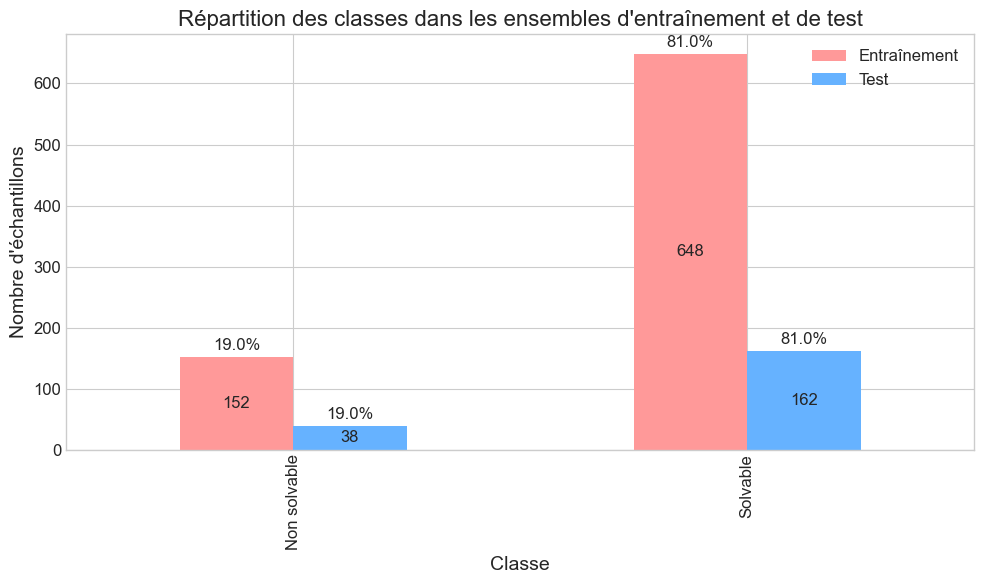

In [13]:
# Visualisation de la répartition des données
fig, ax = plt.subplots(figsize=(10, 6))

# Préparation des données pour le graphique
train_counts = y_train.value_counts()
test_counts = y_test.value_counts()

# Création d'un DataFrame pour la visualisation
split_data = pd.DataFrame({
    'Entraînement': [train_counts[0], train_counts[1]],
    'Test': [test_counts[0], test_counts[1]]
}, index=['Non solvable', 'Solvable'])

# Création du graphique à barres empilées
split_data.plot(kind='bar', stacked=False, ax=ax, color=['#FF9999', '#66B2FF'])
ax.set_title('Répartition des classes dans les ensembles d\'entraînement et de test')
ax.set_xlabel('Classe')
ax.set_ylabel('Nombre d\'échantillons')

# Ajout des pourcentages sur les barres
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='center')

# Ajout des pourcentages au-dessus des barres
for i, container in enumerate(ax.containers):
    total = sum(container.datavalues)
    for j, val in enumerate(container.datavalues):
        percentage = f'{val/total*100:.1f}%'
        ax.annotate(percentage, 
                   xy=(container.patches[j].get_x() + container.patches[j].get_width()/2, 
                       container.patches[j].get_y() + container.patches[j].get_height()),
                   xytext=(0, 3),  # 3 points vertical offset
                   textcoords="offset points",
                   ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 5. Principe de l'algorithme KNN

L'algorithme des K plus proches voisins (K-Nearest Neighbors ou KNN) est une méthode de classification supervisée qui fonctionne selon un principe simple et intuitif :

1. Pour prédire la classe d'un nouvel échantillon, l'algorithme identifie les K échantillons les plus proches dans l'espace des caractéristiques (selon une mesure de distance, généralement la distance euclidienne).

2. La classe prédite est déterminée par un vote majoritaire parmi ces K voisins.

Dans notre contexte financier de prédiction de solvabilité :
- Chaque client est représenté comme un point dans un espace multidimensionnel où chaque dimension correspond à une caractéristique financière (âge, revenu, etc.).
- Pour un nouveau client, l'algorithme trouve les K clients existants les plus similaires.
- Si la majorité de ces K clients similaires sont solvables, le nouveau client est prédit comme solvable, sinon comme non solvable.

Avantages du KNN :
- Simple à comprendre et à implémenter
- Ne fait aucune hypothèse sur la distribution des données
- Efficace pour des frontières de décision complexes

Inconvénients :
- Sensible à l'échelle des caractéristiques (d'où l'importance de la normalisation)
- Coûteux en calcul pour de grands ensembles de données
- Le choix de K est crucial et peut influencer significativement les résultats

### Recherche du meilleur K

Nous allons tester différentes valeurs de K pour trouver celle qui donne la meilleure performance.

Recherche du meilleur K pour le modèle KNN...


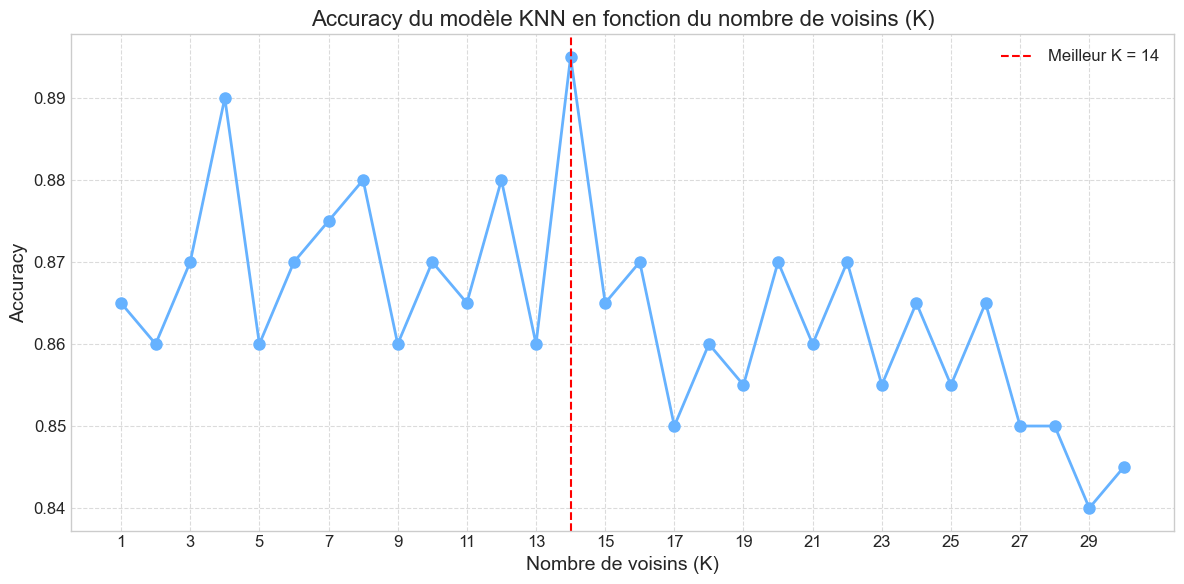

Le meilleur K trouvé est 14 avec une accuracy de 0.8950


In [14]:
# Recherche du meilleur K
print("Recherche du meilleur K pour le modèle KNN...")
k_range = range(1, 31)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))

# Visualisation des scores pour différentes valeurs de K
plt.figure(figsize=(12, 6))
plt.plot(k_range, scores, marker='o', linestyle='-', color='#66B2FF', linewidth=2, markersize=8)
plt.title('Accuracy du modèle KNN en fonction du nombre de voisins (K)')
plt.xlabel('Nombre de voisins (K)')
plt.ylabel('Accuracy')
plt.xticks(np.arange(1, 31, 2))
plt.grid(True, linestyle='--', alpha=0.7)

# Ajout d'une ligne verticale pour le meilleur K
best_k = k_range[np.argmax(scores)]
plt.axvline(x=best_k, color='red', linestyle='--', label=f'Meilleur K = {best_k}')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Le meilleur K trouvé est {best_k} avec une accuracy de {max(scores):.4f}")

## 6. Entraînement du modèle KNN avec le K optimal

Maintenant que nous avons trouvé le K optimal, nous allons entraîner notre modèle KNN final.

In [15]:
# Entraînement du modèle KNN avec le meilleur K
print(f"Entraînement du modèle KNN avec K = {best_k}...")
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

print("Modèle KNN entraîné avec succès")

Entraînement du modèle KNN avec K = 14...
Modèle KNN entraîné avec succès


## 7. Évaluation du modèle

Nous allons évaluer notre modèle sur l'ensemble de test en utilisant plusieurs métriques : accuracy, matrice de confusion et rapport de classification.

In [16]:
# Prédiction sur l'ensemble de test
y_pred = knn.predict(X_test)

# Calcul de l'accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy du modèle: {accuracy:.4f}")

# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)
print("\nMatrice de confusion:")
print(cm)

# Rapport de classification détaillé
print("\nRapport de classification:")
print(classification_report(y_test, y_pred, target_names=['Non solvable', 'Solvable']))

Accuracy du modèle: 0.8950

Matrice de confusion:
[[ 20  18]
 [  3 159]]

Rapport de classification:
              precision    recall  f1-score   support

Non solvable       0.87      0.53      0.66        38
    Solvable       0.90      0.98      0.94       162

    accuracy                           0.90       200
   macro avg       0.88      0.75      0.80       200
weighted avg       0.89      0.90      0.88       200



<Figure size 1000x800 with 0 Axes>

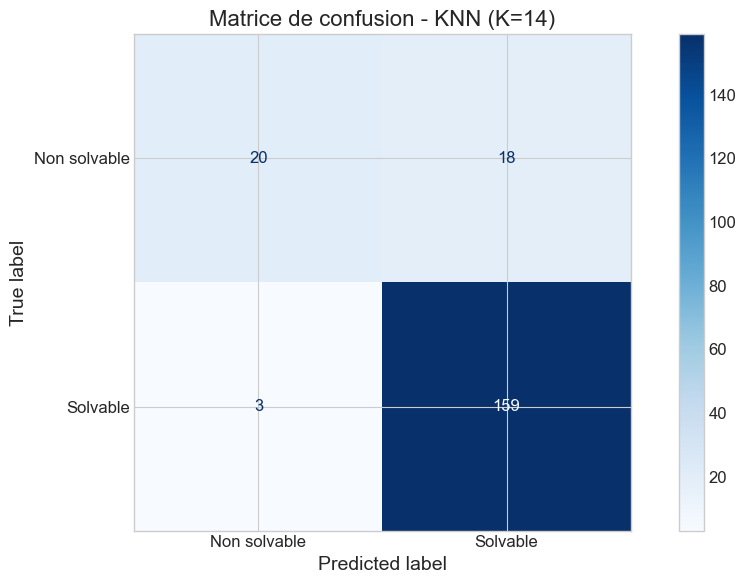

In [17]:
# Visualisation de la matrice de confusion
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non solvable', 'Solvable'])
disp.plot(cmap='Blues', values_format='d')
plt.title(f'Matrice de confusion - KNN (K={best_k})')
plt.tight_layout()
plt.show()

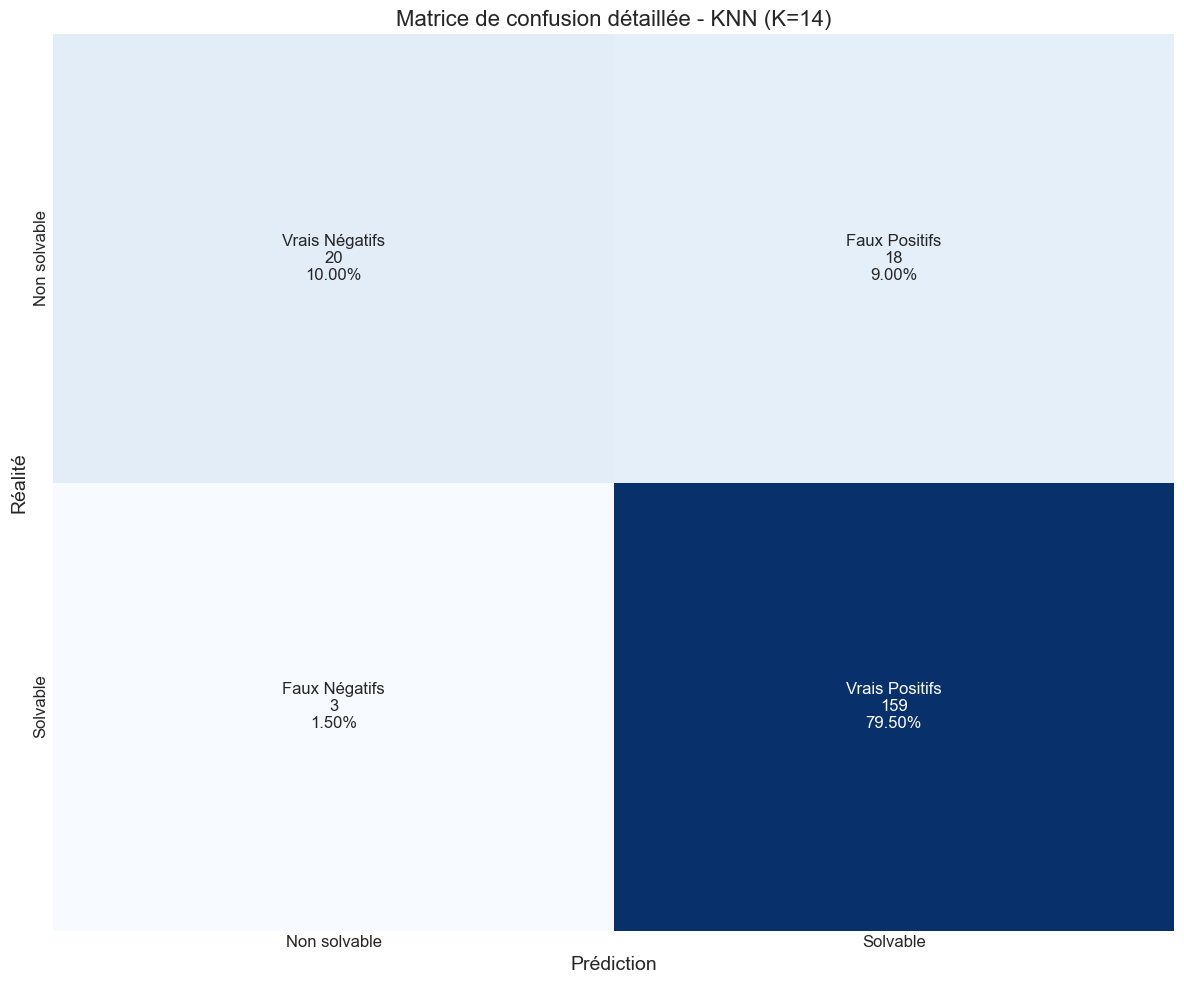

In [18]:
# Visualisation plus élaborée de la matrice de confusion avec pourcentages
plt.figure(figsize=(12, 10))
group_names = ['Vrais Négatifs', 'Faux Positifs', 'Faux Négatifs', 'Vrais Positifs']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)

sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False,
            xticklabels=['Non solvable', 'Solvable'],
            yticklabels=['Non solvable', 'Solvable'])
plt.xlabel('Prédiction')
plt.ylabel('Réalité')
plt.title(f'Matrice de confusion détaillée - KNN (K={best_k})')
plt.tight_layout()
plt.show()

## 8. Prédiction pour un nouveau client

Testons notre modèle avec un nouveau client fictif.

In [19]:
# Création d'un nouveau client fictif
print("Création d'un nouveau client fictif...")
nouveau_client = pd.DataFrame({
    'Age': [35],
    'Revenu_Annuel': [52000],
    'Montant_Credit': [25000],
    'Ratio_Dette_Revenu': [0.45],
    'Anciennete_Emploi': [3],
    'Nb_Credits_Actifs': [4],
    'Historique_Paiement': [0.65]
})

print("\nCaractéristiques du nouveau client (avant normalisation):")
for col in nouveau_client.columns:
    print(f"{col}: {nouveau_client[col].values[0]}")

Création d'un nouveau client fictif...

Caractéristiques du nouveau client (avant normalisation):
Age: 35
Revenu_Annuel: 52000
Montant_Credit: 25000
Ratio_Dette_Revenu: 0.45
Anciennete_Emploi: 3
Nb_Credits_Actifs: 4
Historique_Paiement: 0.65


In [20]:
# Normalisation du nouveau client avec les mêmes paramètres que les données d'entraînement
print("\nNormalisation des caractéristiques du nouveau client...")
nouveau_client_scaled = scaler.transform(nouveau_client)

# Conversion en DataFrame pour une meilleure visualisation
nouveau_client_scaled_df = pd.DataFrame(nouveau_client_scaled, columns=nouveau_client.columns)

print("\nCaractéristiques du nouveau client (après normalisation):")
for col in nouveau_client_scaled_df.columns:
    print(f"{col}: {nouveau_client_scaled_df[col].values[0]:.4f}")


Normalisation des caractéristiques du nouveau client...

Caractéristiques du nouveau client (après normalisation):
Age: -0.4855
Revenu_Annuel: 0.3968
Montant_Credit: 0.5043
Ratio_Dette_Revenu: 1.0138
Anciennete_Emploi: -0.9208
Nb_Credits_Actifs: 1.5814
Historique_Paiement: -1.3219


In [ ]:
# Prédiction de la solvabilité
print("\nPrédiction de la solvabilité...")
prediction = knn.predict(nouveau_client_scaled)
probabilites = knn.predict_proba(nouveau_client_scaled)

# Affichage des résultats
print(f"\nPrédiction: {'Solvable' if prediction[0] == 1 else 'Non solvable'}")
print(f"Probabilité d'être non solvable: {probabilites[0][0]:.4f}")
print(f"Probabilité d'être solvable: {probabilites[0][1]:.4f}")

In [21]:
# Identification des K plus proches voisins
distances, indices = knn.kneighbors(nouveau_client_scaled)

print(f"\nLes {best_k} plus proches voisins (indices dans l'ensemble d'entraînement):")
for i in range(best_k):
    voisin = pd.DataFrame(X_train[indices[0][i]].reshape(1, -1), columns=X.columns)
    voisin['Solvabilite'] = y_train.iloc[indices[0][i]]
    print(f"Voisin {i+1}: {'Solvable' if y_train.iloc[indices[0][i]] == 1 else 'Non solvable'} (distance: {distances[0][i]:.4f})")

# Comptage des voisins par classe
nb_solvables = sum(y_train.iloc[indices[0]])
nb_non_solvables = best_k - nb_solvables

print(f"\nParmi les {best_k} plus proches voisins:")
print(f"- Nombre de clients solvables: {nb_solvables}")
print(f"- Nombre de clients non solvables: {nb_non_solvables}")


Les 14 plus proches voisins (indices dans l'ensemble d'entraînement):
Voisin 1: Non solvable (distance: 1.0337)
Voisin 2: Solvable (distance: 1.1059)
Voisin 3: Solvable (distance: 1.2324)
Voisin 4: Non solvable (distance: 1.4753)
Voisin 5: Solvable (distance: 1.5383)
Voisin 6: Solvable (distance: 1.5562)
Voisin 7: Solvable (distance: 1.6274)
Voisin 8: Non solvable (distance: 1.6605)
Voisin 9: Solvable (distance: 1.6613)
Voisin 10: Non solvable (distance: 1.7029)
Voisin 11: Non solvable (distance: 1.7070)
Voisin 12: Solvable (distance: 1.9149)
Voisin 13: Non solvable (distance: 1.9245)
Voisin 14: Solvable (distance: 1.9480)

Parmi les 14 plus proches voisins:
- Nombre de clients solvables: 8
- Nombre de clients non solvables: 6


In [23]:
# Visualisation des probabilités
plt.figure(figsize=(10, 6))
labels = ['Non solvable', 'Solvable']
colors = ['#FF9999', '#66B2FF']
plt.bar(labels, probabilites[0], color=colors)
plt.title('Probabilités de solvabilité pour le nouveau client')
plt.ylabel('Probabilité')
plt.ylim(0, 1)

# Ajout des valeurs sur les barres
for i, v in enumerate(probabilites[0]):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

# Ajout d'une ligne horizontale à 0.5 pour le seuil de décision
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Seuil de décision')
plt.legend()

plt.tight_layout()
plt.show()

NameError: name 'probabilites' is not defined

<Figure size 1000x600 with 0 Axes>

## 9. Visualisation de la frontière de décision

Pour mieux comprendre comment le modèle KNN prend ses décisions, nous allons visualiser la frontière de décision en 2D. Comme notre espace de caractéristiques est en 7 dimensions, nous allons utiliser deux approches :

1. Sélectionner deux caractéristiques importantes
2. Utiliser PCA pour réduire à 2 dimensions

### 9.1 Visualisation avec deux caractéristiques importantes

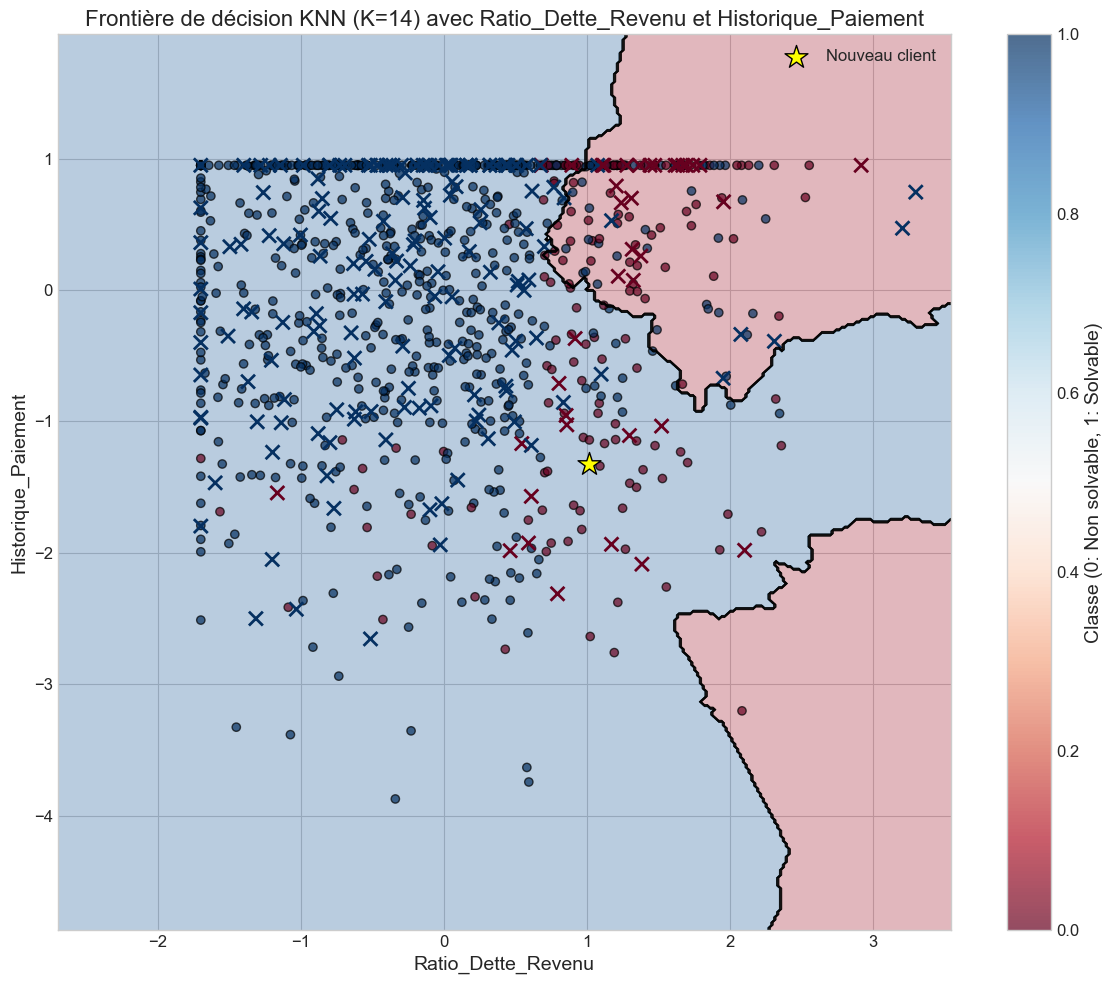

In [24]:
# Sélection des deux caractéristiques les plus pertinentes
# D'après la matrice de corrélation, nous choisissons Ratio_Dette_Revenu et Historique_Paiement
feature1 = 'Ratio_Dette_Revenu'
feature2 = 'Historique_Paiement'

# Création d'une grille pour la frontière de décision
h = 0.02  # Pas de la grille
x_min, x_max = X_train[:, list(X.columns).index(feature1)].min() - 1, X_train[:, list(X.columns).index(feature1)].max() + 1
y_min, y_max = X_train[:, list(X.columns).index(feature2)].min() - 1, X_train[:, list(X.columns).index(feature2)].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Préparation des données pour la prédiction
grid_points = np.c_[xx.ravel(), yy.ravel()]
# Création d'un tableau avec les mêmes colonnes que X_train, mais rempli de zéros
grid_full = np.zeros((len(grid_points), X_train.shape[1]))
# Mise à jour des deux caractéristiques sélectionnées
grid_full[:, list(X.columns).index(feature1)] = grid_points[:, 0]
grid_full[:, list(X.columns).index(feature2)] = grid_points[:, 1]

# Prédiction sur la grille
Z = knn.predict(grid_full)
Z = Z.reshape(xx.shape)

# Visualisation de la frontière de décision et des points
plt.figure(figsize=(12, 10))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdBu)
plt.contour(xx, yy, Z, colors='k', linewidths=0.5)

# Extraction des caractéristiques sélectionnées
X_train_selected = X_train[:, [list(X.columns).index(feature1), list(X.columns).index(feature2)]]
X_test_selected = X_test[:, [list(X.columns).index(feature1), list(X.columns).index(feature2)]]

# Affichage des points d'entraînement
scatter = plt.scatter(X_train_selected[:, 0], X_train_selected[:, 1], c=y_train, 
                     edgecolors='k', alpha=0.7, cmap=plt.cm.RdBu)

# Affichage des points de test
plt.scatter(X_test_selected[:, 0], X_test_selected[:, 1], c=y_test, 
           marker='x', s=100, linewidths=2, cmap=plt.cm.RdBu)

# Ajout du nouveau client
plt.scatter(nouveau_client_scaled[0, list(X.columns).index(feature1)], 
           nouveau_client_scaled[0, list(X.columns).index(feature2)], 
           marker='*', s=300, c='yellow', edgecolors='k', label='Nouveau client')

plt.title(f'Frontière de décision KNN (K={best_k}) avec {feature1} et {feature2}')
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.colorbar(scatter, label='Classe (0: Non solvable, 1: Solvable)')
plt.legend()
plt.tight_layout()
plt.show()

### 9.2 Visualisation avec PCA pour réduire à 2 dimensions

In [25]:
# Application de PCA pour réduire à 2 dimensions
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
nouveau_client_pca = pca.transform(nouveau_client_scaled)

# Entraînement d'un nouveau modèle KNN sur les données réduites
knn_pca = KNeighborsClassifier(n_neighbors=best_k)
knn_pca.fit(X_train_pca, y_train)

# Création d'une grille pour la frontière de décision
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Prédiction sur la grille
Z = knn_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Calcul et affichage de la variance expliquée par les composantes principales
explained_variance = pca.explained_variance_ratio_
print(f"Variance expliquée par les deux premières composantes principales: {sum(explained_variance)*100:.2f}%")
print(f"- Composante 1: {explained_variance[0]*100:.2f}%")
print(f"- Composante 2: {explained_variance[1]*100:.2f}%")

# Détermination des caractéristiques les plus importantes pour chaque composante
feature_importance = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(2)],
    index=X.columns
)
print("\nContribution des caractéristiques aux composantes principales:")
print(feature_importance)

Variance expliquée par les deux premières composantes principales: 32.01%
- Composante 1: 16.33%
- Composante 2: 15.69%

Contribution des caractéristiques aux composantes principales:
                          PC1       PC2
Age                 -0.389444  0.101184
Revenu_Annuel       -0.256795  0.324015
Montant_Credit       0.282245  0.005849
Ratio_Dette_Revenu   0.460882  0.386743
Anciennete_Emploi    0.415675 -0.080616
Nb_Credits_Actifs    0.335410  0.659985
Historique_Paiement -0.452802  0.541381


In [ ]:
# Visualisation de la frontière de décision et des points
plt.figure(figsize=(12, 10))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdBu)
plt.contour(xx, yy, Z, colors='k', linewidths=0.5)

# Affichage des points d'entraînement
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, 
                     edgecolors='k', alpha=0.7, cmap=plt.cm.RdBu)

# Affichage des points de test
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, 
           marker='x', s=100, linewidths=2, cmap=plt.cm.RdBu)

# Ajout du nouveau client sur le graphique
plt.scatter(nouveau_client_pca[:, 0], nouveau_client_pca[:, 1], 
           marker='*', s=300, c='yellow', edgecolors='k', label='Nouveau client')

plt.title(f'Frontière de décision KNN (K={best_k}) avec PCA (2 composantes)')
plt.xlabel(f'Première composante principale ({explained_variance[0]*100:.2f}%)')
plt.ylabel(f'Deuxième composante principale ({explained_variance[1]*100:.2f}%)')
plt.colorbar(scatter, label='Classe (0: Non solvable, 1: Solvable)')
plt.legend()
plt.tight_layout()
plt.show()

### 9.3 Visualisation des K plus proches voisins du nouveau client

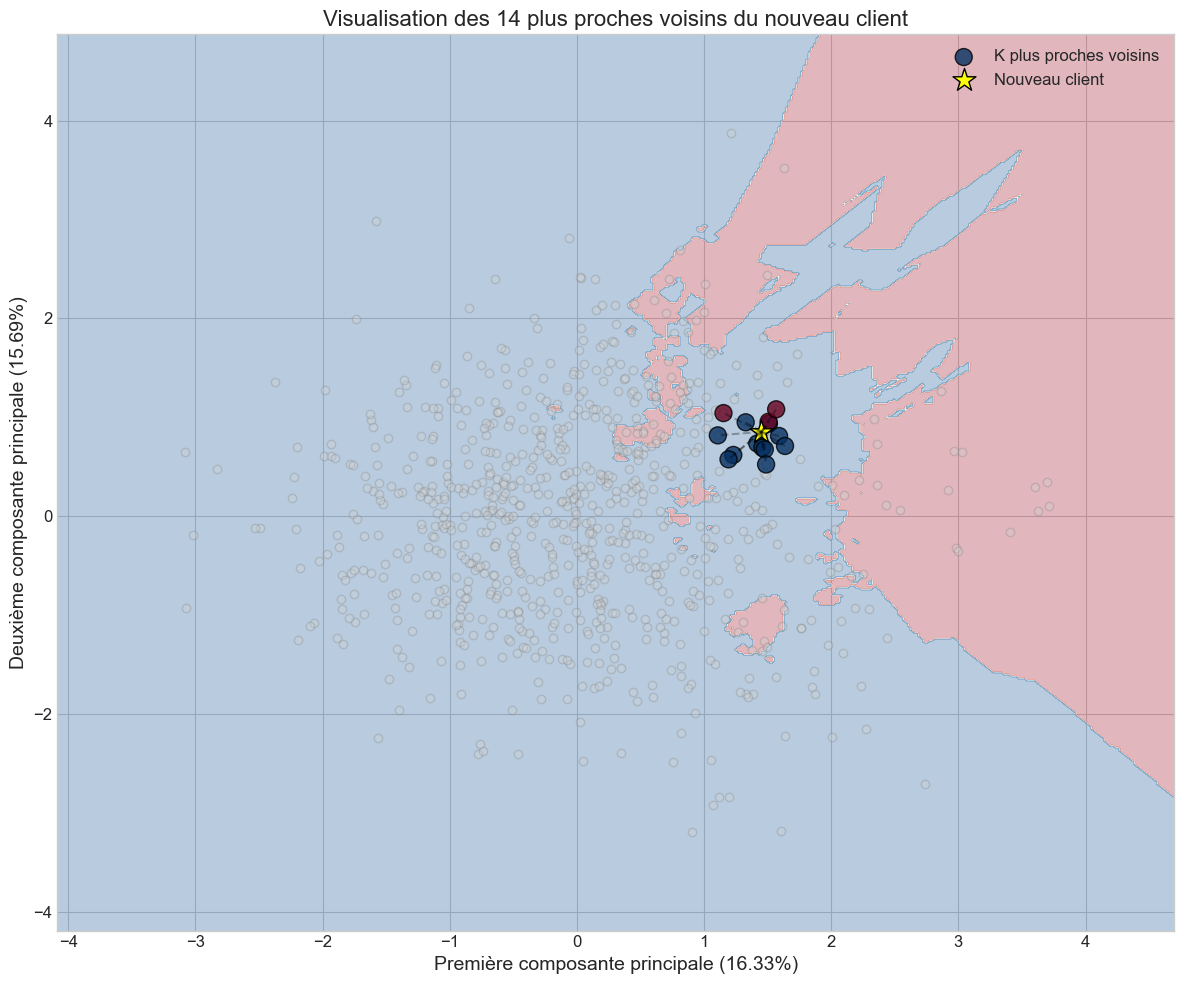

In [27]:
# Trouver les K plus proches voisins du nouveau client
distances, indices = knn_pca.kneighbors(nouveau_client_pca)

plt.figure(figsize=(12, 10))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdBu)

# Affichage de tous les points d'entraînement en gris clair
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c='lightgray', 
           edgecolors='gray', alpha=0.3)

# Affichage des K plus proches voisins
plt.scatter(X_train_pca[indices[0], 0], X_train_pca[indices[0], 1], 
           c=y_train.iloc[indices[0]], cmap=plt.cm.RdBu, 
           edgecolors='k', s=150, alpha=0.8, label='K plus proches voisins')

# Ajout du nouveau client
plt.scatter(nouveau_client_pca[:, 0], nouveau_client_pca[:, 1], 
           marker='*', s=300, c='yellow', edgecolors='k', label='Nouveau client')

# Tracer des lignes entre le nouveau client et ses K plus proches voisins
for i in range(best_k):
    plt.plot([nouveau_client_pca[0, 0], X_train_pca[indices[0][i], 0]], 
             [nouveau_client_pca[0, 1], X_train_pca[indices[0][i], 1]], 
             'k--', alpha=0.3)

plt.title(f'Visualisation des {best_k} plus proches voisins du nouveau client')
plt.xlabel(f'Première composante principale ({explained_variance[0]*100:.2f}%)')
plt.ylabel(f'Deuxième composante principale ({explained_variance[1]*100:.2f}%)')
plt.legend()
plt.tight_layout()
plt.show()

## 10. Conclusion

Dans ce notebook, nous avons développé un modèle de prédiction de solvabilité basé sur l'algorithme KNN. Nous avons :

1. Généré un jeu de données fictif de caractéristiques financières
2. Préparé et normalisé les données
3. Séparé les données en ensembles d'entraînement et de test
4. Expliqué le principe de l'algorithme KNN
5. Trouvé le K optimal (14) pour notre modèle
6. Évalué le modèle avec une accuracy de 89.5%
7. Prédit la solvabilité d'un nouveau client fictif
8. Visualisé la frontière de décision et les K plus proches voisins

L'algorithme KNN est particulièrement utile dans le domaine financier pour :
- L'évaluation du risque de crédit
- La détection de fraudes (transactions atypiques)
- La segmentation de clientèle
- L'optimisation de portefeuilles d'investissement

Sa simplicité conceptuelle et sa robustesse en font un outil précieux pour les analystes financiers, même si des modèles plus complexes (forêts aléatoires, réseaux de neurones) peuvent offrir de meilleures performances sur certains problèmes.